# Swift-Hohenberg (Non-Conserved) Phase Field Crystal (PFC) Model

FiPy implementation of (Provatas & Elder, 2009): Figure 8.6

> Two dimensional ordering in the Swift-Hohenberg equation with extra cubic term in free energy functional (see Eq. (8.44)). 

> $$\mathcal{F} = \int d\vec{r}\left[
    \frac{1}{2}\psi\left(
        -\epsilon
        + \left(
            q_0^2 + \nabla^2
        \right)^2
    \right)\psi
    + \alpha \frac{\psi^3}{3}
    + \frac{\psi^4}{4}
\right] 
\tag{8.44}
$$

## Imports

In [1]:
import fipy as fp

## Parameters

> These simulations were conducted for ($\epsilon$, $q_0$, $\Gamma$, $D$, $\alpha$) = (0.1, 1, 1, 0, 1/2), 

In [2]:
epsilon = 0.1
q0 = 1
Gamma = 1
D = 0
alpha = 1/2

## Domain

> in a system of size (128 × 128) 

In [3]:
mesh = fp.Grid2D(nx=128, ny=128)

## Equations

Given the evolution equation for a non-conserved order parameter
> $$\frac{\partial\psi}{\partial t} 
= -\Gamma\frac{\delta\mathcal{F}}{\delta\psi} + \eta
\tag{8.10}
$$
where $\Gamma$ is a phenomenological parameter that can be scaled out, $\eta$ is a Gaussian random noise term with correlations $\langle\eta\rangle = 0$ and 
$\langle\eta(\vec{r},t)\eta(\vec{r}',t')\rangle = 2\Gamma D \delta(\vec{r} - \vec{r}')\delta(t-t')$ and $D$ is the noise strength.

In [4]:
psi = fp.CellVariable(mesh=mesh, name=r"$\psi$", hasOld=True)

The driving force is obtained from (8.44) as

$$\begin{align*}
\frac{\delta\mathcal{F}}{\delta\psi}
&=
\left(
    -\epsilon
    + \left(
        q_0^2 + \nabla^2
    \right)^2
\right)\psi
+ \alpha \psi^2
+ \psi^3
\\
&=
\left(
    -\epsilon\psi
    + \left(
        q_0^2 + \nabla^2
    \right)
    \xi
\right)
+ \alpha \psi^2
+ \psi^3
\end{align*}$$

where we introduce
$$\xi \equiv \left(q_0^2 + \nabla^2\right)\psi$$
such that all terms are no more than 2nd order.

In [5]:
xi = fp.CellVariable(mesh=mesh, name=r"$\xi$")

In [6]:
xi_eq = (fp.ImplicitSourceTerm(coeff=1, var=xi)
         == fp.ImplicitSourceTerm(coeff=q0**2, var=psi)
         + fp.DiffusionTerm(coeff=1, var=psi))

Therefore,

$$\begin{align*}
\frac{\partial\psi}{\partial t} 
&= -\Gamma\left[
    \left(
        -\epsilon\psi
        + \left(
            q_0^2 + \nabla^2
        \right)
        \xi
    \right)
    + \alpha \psi^2
    + \psi^3
\right] + \eta
\\
&= \Gamma\left(
        \epsilon
        - \alpha\psi
        - \psi^2
    \right)\psi
    - \Gamma q_0^2 \xi
    - \Gamma\nabla^2\xi
    + \eta
\end{align*}$$

(we ignore $\eta$ as $D=0$).

In [7]:
psi_eq = (fp.TransientTerm(var=psi)
          == fp.ImplicitSourceTerm(coeff=Gamma*(epsilon - alpha*psi - psi**2), var=psi)
          - fp.ImplicitSourceTerm(coeff=Gamma*q0**2, var=xi)
          - fp.DiffusionTerm(coeff=Gamma, var=xi))

We solve $\psi$ and $\xi$ together

In [8]:
eq = psi_eq & xi_eq

## Initial Conditions

Initialize $\psi$ with Gaussian noise

In [32]:
psi.setValue(fp.GaussianNoiseVariable(mesh=mesh))
xi.setValue(0)

## Visualize results

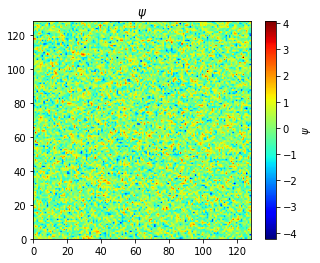

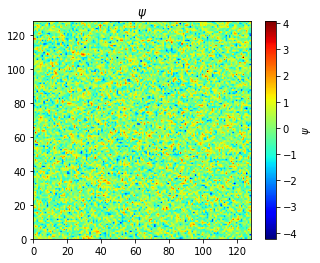

In [13]:
viewer = fp.Viewer(vars=psi)
viewer.plot()

## Solution

> Figs a), b) c), d) correspond to times t = 100, 200, 400 and 800 respectively.

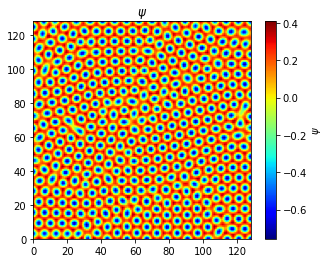

<Figure size 432x288 with 0 Axes>

In [33]:
t = 0
dt = 1
for step in range(800):
    psi.updateOld()
    eq.solve(dt=dt)
    t += dt
    if t % 10 == 0:
        viewer.plot()

## References

N. Provatas and K. Elder, 
*Phase-Field Methods in Materials Science and Engineering*, 
Wiley-VCH, 2009